In [15]:
!wget -O t10k-images.idx3-ubyte https://github.com/akhilasana/handwritten_digit_recognition_with-lenet5-model_using-pytorch/raw/main/MNIST_dataset/t10k-images.idx3-ubyte
!wget -O t10k-labels.idx1-ubyte https://github.com/akhilasana/handwritten_digit_recognition_with-lenet5-model_using-pytorch/raw/main/MNIST_dataset/t10k-labels.idx1-ubyte

--2024-07-08 14:27:54--  https://github.com/akhilasana/handwritten_digit_recognition_with-lenet5-model_using-pytorch/raw/main/MNIST_dataset/t10k-images.idx3-ubyte
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/akhilasana/handwritten_digit_recognition_with-lenet5-model_using-pytorch/main/MNIST_dataset/t10k-images.idx3-ubyte [following]
--2024-07-08 14:27:54--  https://raw.githubusercontent.com/akhilasana/handwritten_digit_recognition_with-lenet5-model_using-pytorch/main/MNIST_dataset/t10k-images.idx3-ubyte
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7840016 (7.5M) [application/octet-stream]


In [16]:
import numpy as np
import struct

def read_idx(filename):
    with open(filename, 'rb') as f:
        # Read the magic number
        magic = struct.unpack('>I', f.read(4))[0]
        # Read the number of dimensions
        dims = magic & 0xFF
        # Read the shape of the array
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        # Read the data
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')


In [17]:
print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
print(f'Number of images: {len(images)}')
print(f'Number of labels: {len(labels)}')

Images shape: (10000, 28, 28)
Labels shape: (10000,)
Number of images: 10000
Number of labels: 10000


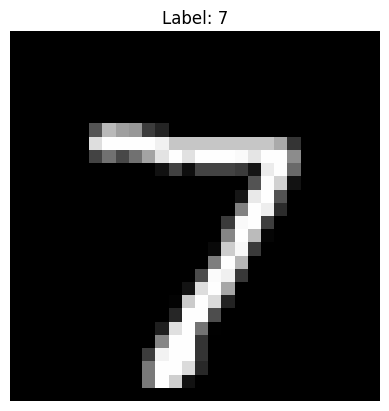

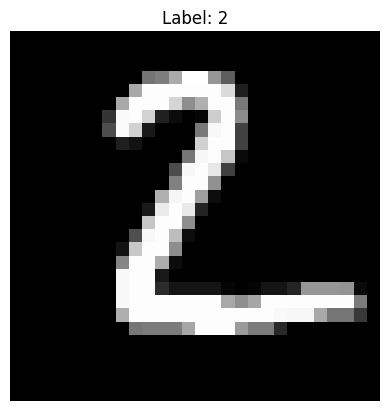

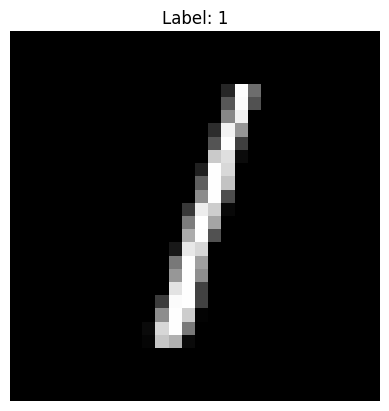

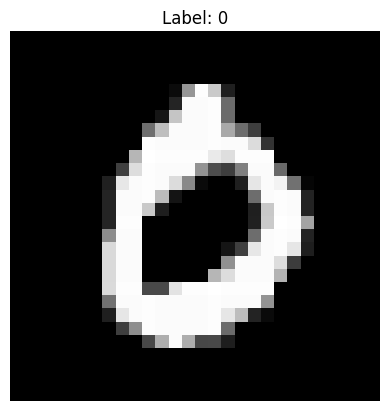

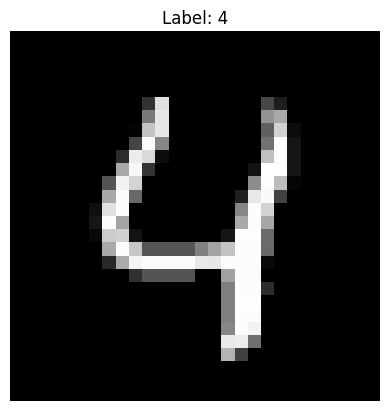

In [18]:
def display_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

for i in range(5):
    display_image(images[i], labels[i])

In [19]:
import torch

# Assuming you've loaded your data using the provided functions
images = read_idx('t10k-images.idx3-ubyte')
labels = read_idx('t10k-labels.idx1-ubyte')

# Define LeNet input shape (assuming grayscale images)
leNet_input_shape = (1, 28, 28)

# Reshape images to match LeNet's input shape
reshaped_images = images.reshape(-1, *leNet_input_shape)  # Reshape with -1 for batch size

print("Original images shape:", images.shape)
print("Reshaped images shape:", reshaped_images.shape)

# Convert data type to float for PyTorch (optional, might be needed depending on your model)
reshaped_images = reshaped_images.astype(np.float32) / 255.0  # Normalize pixel values

print("Data type after reshaping:", reshaped_images.dtype)


Original images shape: (10000, 28, 28)
Reshaped images shape: (10000, 1, 28, 28)
Data type after reshaping: float32


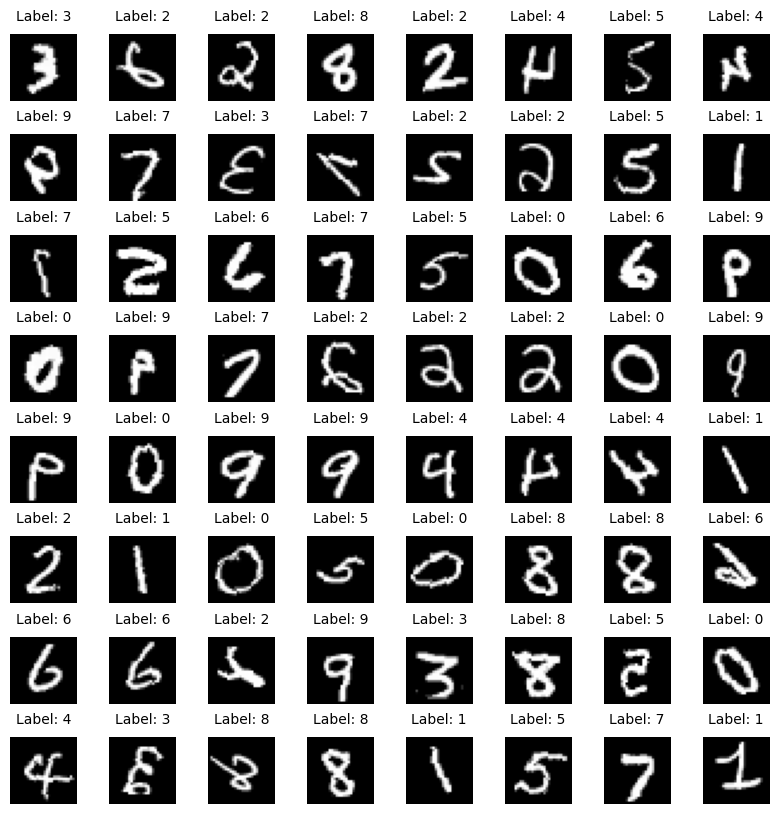

In [20]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the datasets with the defined transformations
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define a custom collate function for one-hot encoding
def one_hot_collate(batch, num_classes=10):
    images, labels = zip(*batch)
    images = torch.stack(images)
    labels = torch.tensor(labels)
    one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
    return images, one_hot_labels

# Use the custom collate function in the DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, collate_fn=lambda x: one_hot_collate(x))
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, collate_fn=lambda x: one_hot_collate(x))

# Function to show a batch of images and labels
def show_batch(batch):
    images, labels = batch
    batch_size = len(images)
    nrows = int(np.sqrt(batch_size))
    ncols = (batch_size // nrows) + (batch_size % nrows > 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < batch_size:
            ax.imshow(images[i][0], cmap='gray')
            ax.set_title(f'Label: {labels[i].argmax().item()}', fontsize=10, pad=10)
        ax.axis('off')
    plt.show()

# Display a batch of images and their one-hot encoded labels
dataiter = iter(trainloader)
batch = next(dataiter)
show_batch(batch)


Sample One-Hot Encoded Labels:
Label 0: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Label 1: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Label 2: tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
Label 3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
Label 4: tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])


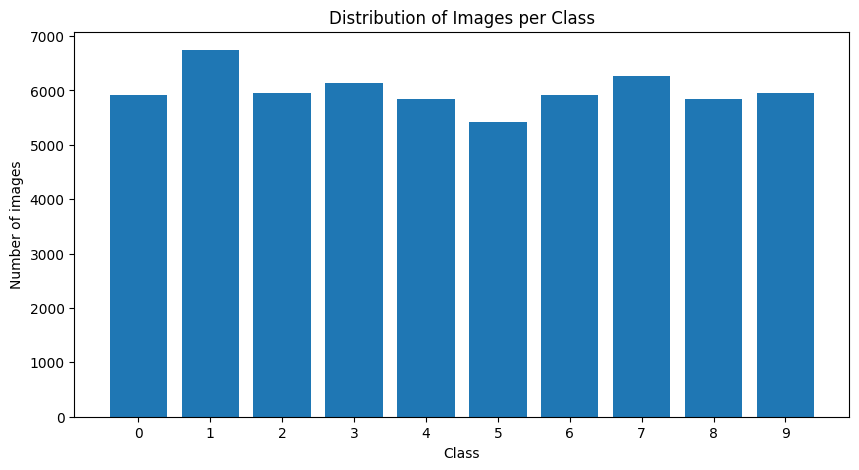

In [21]:
# Display a sample of one-hot encoded labels
def display_sample_labels(loader, num_samples=5):
    dataiter = iter(loader)
    images, one_hot_labels = next(dataiter)
    print("Sample One-Hot Encoded Labels:")
    for i in range(num_samples):
        print(f"Label {i}: {one_hot_labels[i]}")

# Display sample one-hot encoded labels from the trainloader
display_sample_labels(trainloader, num_samples=5)
# Count the number of images per class and visualize the distribution
def visualize_class_distribution(loader):
    class_counts = torch.zeros(10)
    for images, one_hot_labels in loader:
        labels = one_hot_labels.argmax(dim=1)
        for label in labels:
            class_counts[label] += 1

    # Plot the distribution
    classes = [str(i) for i in range(10)]
    plt.figure(figsize=(10, 5))
    plt.bar(classes, class_counts)
    plt.xlabel('Class')
    plt.ylabel('Number of images')
    plt.title('Distribution of Images per Class')
    plt.show()

# Visualize the distribution of images per class in the trainloader
visualize_class_distribution(trainloader)


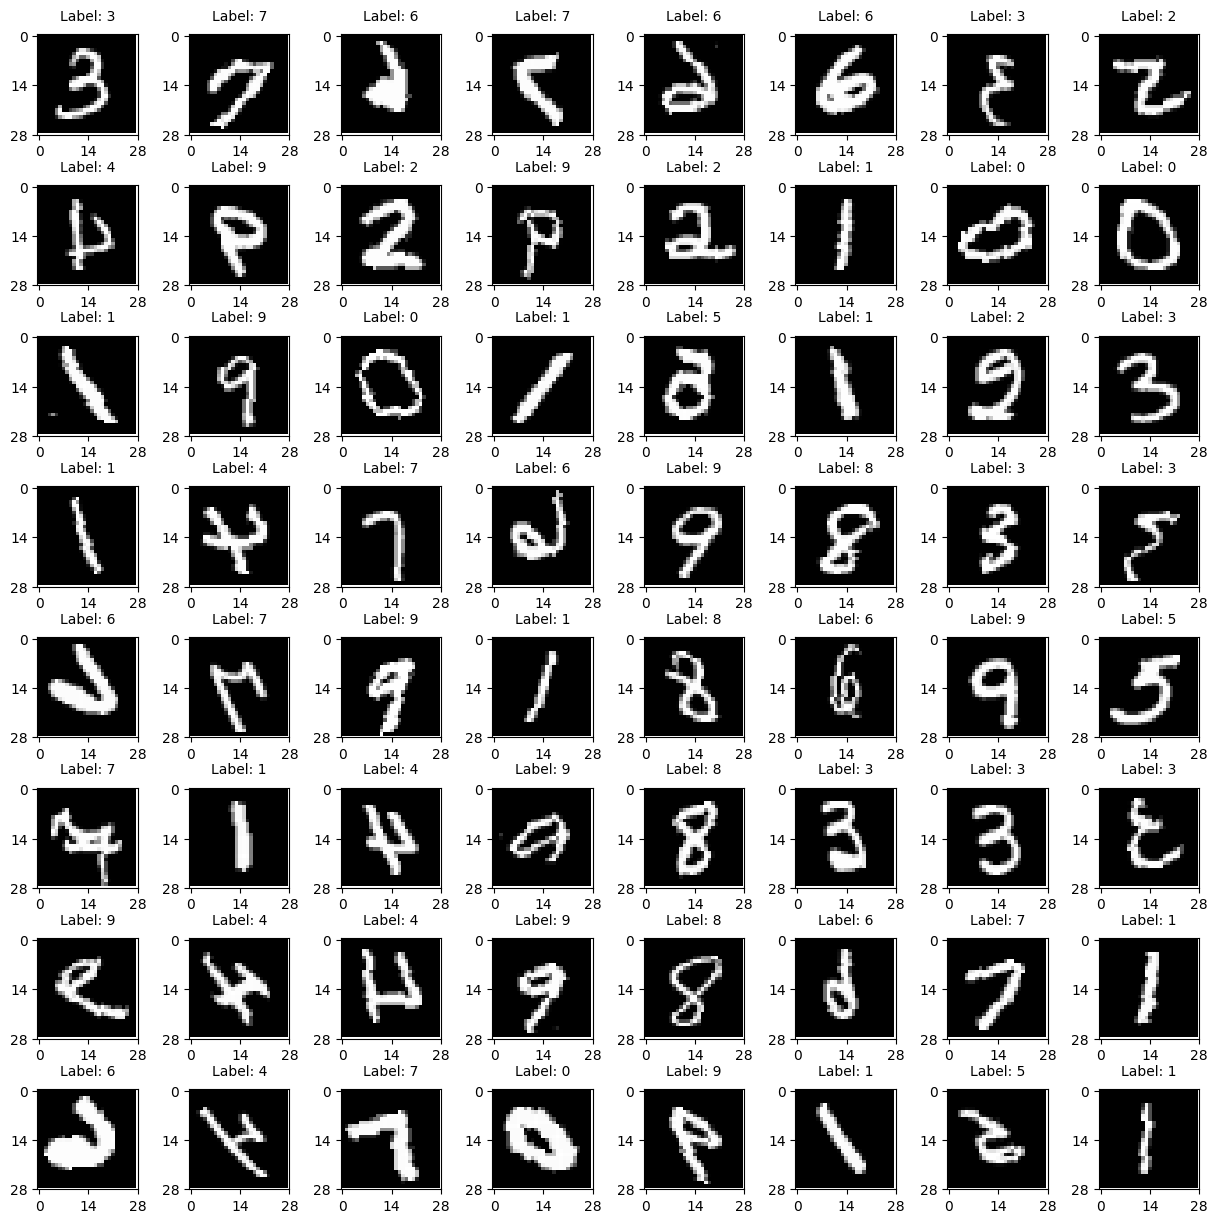

In [22]:
# Function to show a batch of images with their dimensions and labels
def show_batch(batch):
    images, one_hot_labels = batch
    labels = one_hot_labels.argmax(dim=1)  # Convert one-hot labels to class indices
    batch_size = len(images)
    nrows = int(np.sqrt(batch_size))
    ncols = (batch_size // nrows) + (batch_size % nrows > 0)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))  # Increased figure size
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Added more space between subplots
    for i, ax in enumerate(axes.flat):
        if i < batch_size:
            image = images[i][0]
            ax.imshow(image, cmap='gray')
            ax.set_title(f'Label: {labels[i].item()}', fontsize=10, pad=10)
            # Set custom ticks to show dimensions
            ax.set_xticks([0, image.shape[1]//2, image.shape[1]])
            ax.set_xticklabels([0, image.shape[1]//2, image.shape[1]])
            ax.set_yticks([0, image.shape[0]//2, image.shape[0]])
            ax.set_yticklabels([0, image.shape[0]//2, image.shape[0]])
        ax.axis('on')
    plt.show()

# Load a batch and display it
dataiter = iter(trainloader)
batch = next(dataiter)
show_batch(batch)

Number of samples in the training set: 6000
Number of samples in the validation set: 2000
Number of samples in the test set: 2000


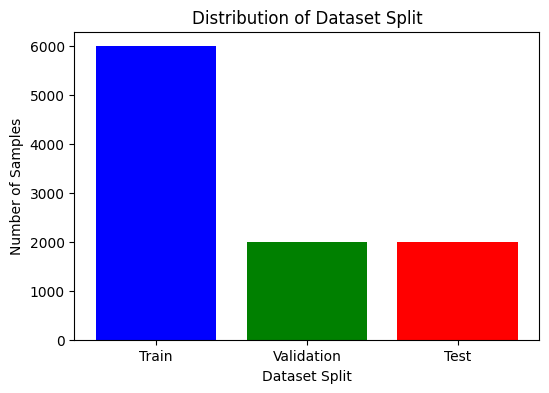

In [23]:
from torch.utils.data import random_split, TensorDataset
import matplotlib.pyplot as plt

# Assume images and labels have been loaded as NumPy arrays
# Convert images and labels to tensors
images_tensor = torch.tensor(images).float() / 255.0  # Normalize the images
labels_tensor = torch.tensor(labels)

# Create a dataset from images and labels
dataset = TensorDataset(images_tensor, labels_tensor)

# Define the sizes of train, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes of train, validation, and test sets
print(f"Number of samples in the training set: {len(train_dataset)}")
print(f"Number of samples in the validation set: {len(val_dataset)}")
print(f"Number of samples in the test set: {len(test_dataset)}")

# Sizes of train, validation, and test sets
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
labels = ['Train', 'Validation', 'Test']

# Plotting the bar chart
plt.figure(figsize=(6, 4))
plt.bar(labels, sizes, color=['blue', 'green', 'red'])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.title('Distribution of Dataset Split')
plt.show()
